In [1]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/fruits-360.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [2]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

In [3]:
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '/content/fruits-360/Training'
validation_data_dir = '/content/fruits-360/Test'
 
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
from keras.applications.resnet import ResNet50  
#import inception with pre-trained weights. do not include fully #connected layers
basemodel = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = basemodel.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
# and a fully connected output/classification layer
predictions = Dense(131, activation='sigmoid')(x)
# create the full network so we can train on it
model = Model(inputs=basemodel.input, outputs=predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [6]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(learning_rate=0.001,rho=0.95,epsilon=1e-07,name='Adadelta'),metrics=['accuracy'])

In [7]:
history_pretrained =model.fit_generator(train_generator,epochs=5, shuffle = True, verbose = 1, validation_data = validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2116/2116 [==============================] - 987s 439ms/step - loss: 4.6670 - accuracy: 0.0699 - val_loss: 2.9924 - val_accuracy: 0.5104
Epoch 2/5
2116/2116 [==============================] - 920s 434ms/step - loss: 2.7322 - accuracy: 0.5388 - val_loss: 1.1856 - val_accuracy: 0.8408
Epoch 3/5
2116/2116 [==============================] - 917s 433ms/step - loss: 1.1339 - accuracy: 0.8500 - val_loss: 0.3916 - val_accuracy: 0.9454
Epoch 4/5
2116/2116 [==============================] - 914s 432ms/step - loss: 0.4315 - accuracy: 0.9467 - val_loss: 0.1823 - val_accuracy: 0.9707
Epoch 5/5
2116/2116 [==============================] - 921s 435ms/step - loss: 0.2051 - accuracy: 0.9754 - val_loss: 0.1163 - val_accuracy: 0.9784


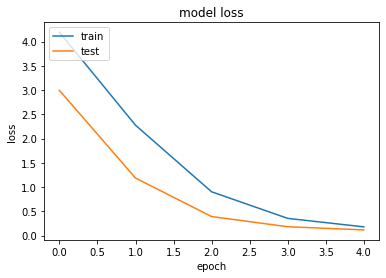

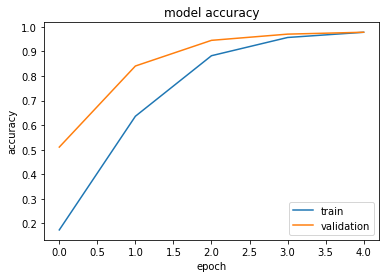

In [8]:
import matplotlib.pyplot as plt
plt.plot(history_pretrained .history['loss'])
plt.plot(history_pretrained .history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_pretrained .history['accuracy'])
plt.plot(history_pretrained .history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [13]:
model.evaluate(validation_generator,verbose=2)

709/709 - 75s - loss: 0.1163 - accuracy: 0.9784


[0.116337850689888, 0.9784467816352844]

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

 
# Y_pred=model.predict(validation_generator)
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = model.predict_generator(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
 
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
print(classification_report(validation_generator.classes,y_pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


709/709 [==============================] - 78s 105ms/step
              precision    recall  f1-score   support

           0       0.02      0.03      0.03       164
           1       0.01      0.01      0.01       148
           2       0.01      0.01      0.01       160
           3       0.01      0.01      0.01       164
           4       0.01      0.01      0.01       161
           5       0.00      0.00      0.00       164
           6       0.02      0.02      0.02       152
           7       0.00      0.00      0.00       164
           8       0.02      0.01      0.01       164
           9       0.01      0.01      0.01       144
          10       0.01      0.01      0.01       166
          11       0.04      0.04      0.04       164
          12       0.01      0.01      0.01       219
          13       0.01      0.01      0.01       164
          14       0.02      0.02      0.02       143
          15       0.01      0.01      0.01       166
          16       0.00

In [10]:
cm=confusion_matrix(validation_generator.classes,y_pred)
cm

array([[5, 1, 1, ..., 1, 5, 0],
       [2, 1, 2, ..., 2, 2, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 2, 0, ..., 2, 1, 2],
       [2, 3, 3, ..., 3, 2, 2],
       [0, 0, 0, ..., 0, 1, 1]])

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
P=precision_score(validation_generator.classes, y_pred, average="macro")  
print(P*100)
from sklearn.metrics import accuracy_score
A=accuracy_score(validation_generator.classes, y_pred)
print(A*100)
from sklearn.metrics import f1_score
f1=f1_score(validation_generator.classes, y_pred,average='micro')
print(f1*100)

0.7722215162281593
0.8242242595204513
0.8242242595204513


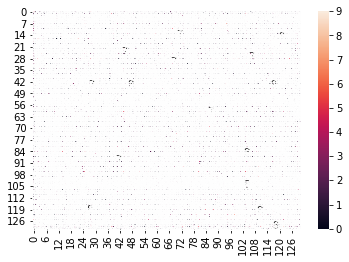

In [12]:
import seaborn as sns
sns.heatmap(cm,annot=True)